## Import Module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv

from numpy import percentile

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, Flatten,Dense, Activation
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, r2_score


Using TensorFlow backend.


## Load Data

In [2]:
data = pd.read_table("driving_dataset/data.txt",delimiter = ' ',names= ['files','angles'], dtype ={'results': np.float16})

## Round Angles

In [3]:
data['angles'] = np.round(data['angles'])

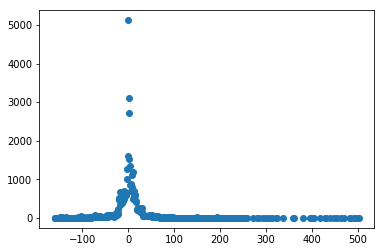

In [4]:
plt.scatter(data.angles.value_counts().index, data.angles.value_counts())

## DROP DATA

### Drop occcurrences < 200

In [5]:
lessthan200 = data.angles.value_counts() <200
selected_angles = data.angles.value_counts()[lessthan200].index.to_list()

In [6]:
for angle in selected_angles:
    data = data.loc[data.angles != angle]

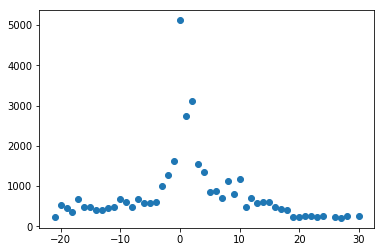

In [7]:
plt.scatter(data.angles.value_counts().index, data.angles.value_counts())

### Keep at most 3000 for each angle

In [8]:
#shuffle Dataframe, reset indexes
data.sample(frac=1)
data = data.sample(frac=1).reset_index(drop=True)

In [9]:
morethan3000 = data.angles.value_counts() >3000
selected_angles = data.angles.value_counts()[morethan3000].index.to_list()

In [10]:
for angle in selected_angles:
    df = data.loc[data.angles == angle]
    num_drop = round(df.shape[0] - 3000)
    portion_drop = df.iloc[:num_drop,:]
    data = pd.concat([data, portion_drop]).drop_duplicates(keep = False)

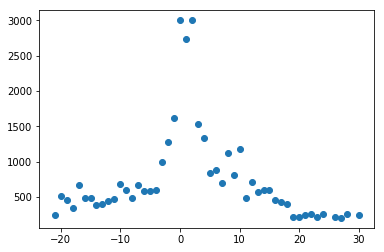

In [11]:
plt.scatter(data.angles.value_counts().index, data.angles.value_counts())

### Remove Outliers

Upper =  24.5
Lower =  -19.5


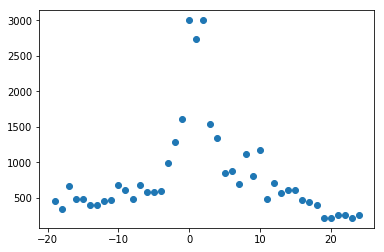

In [12]:
q25, q75 = percentile(data.angles, 25), percentile(data.angles, 75)
iqr = q75 - q25
lower, upper = q25 - 1.5*iqr, q75 + 1.5*iqr
print('Upper = ', upper)
print('Lower = ', lower)
data = data.loc[data.angles > lower]
data = data.loc[data.angles < upper]
plt.scatter(data.angles.value_counts().index, data.angles.value_counts())

## Scale Pixels

In [13]:
def preprocess_img(path):
    img = mpimg.imread(path)
    part = img[150:,:,:]
    img = cv.cvtColor(part, cv.COLOR_RGB2YUV)
    img = cv.GaussianBlur(img,(3,3),0)
    img = cv.resize(img, (200,66))
    img = img/255
    return img
  

## Split Data

In [14]:
#shuffle Dataframe, reset indexes
data.sample(frac=1)
data = data.sample(frac=1).reset_index(drop=True)

In [15]:
def split_df(df,train_per, val_per):
    df = df.sample(frac=1).reset_index(drop=True)
    total_samples = df.shape[0]

    num_train = total_samples * train_per
    num_val = total_samples* val_per
    
    train_df = df.loc[:num_train]
    val_df = df.loc[num_train:(num_train + num_val)]
    test_df = df.loc[(num_train + num_val):]

    return train_df, val_df, test_df

In [16]:
train_df, val_df, test_df = split_df(data,train_per = 0.75, val_per= 0.22)
print("number of training data",train_df.shape[0])
print("number of validation data", val_df.shape[0])
print("number of testing data", test_df.shape[0])

number of training data 26340
number of validation data 7726
number of testing data 1053


## Create a batch generator

In [17]:
def batch_generator(df,batch_size):
    while True:
        batch = df.sample(n = batch_size)
        batch_paths  =  "driving_dataset/" + batch['files']
        df_angles = batch['angles'] 

        batch_imgs = np.asarray(list(map(preprocess_img, batch_paths)))
        batch_angles = np.asarray(df_angles)

        yield (batch_imgs, batch_angles)
  

## Create a model

In [18]:
def create_model():
    model = Sequential()
    model.add(Conv2D(24,(5,5),padding ="valid",strides = (2,2), input_shape = (66,200,3),activation = 'elu'))
    model.add(Conv2D(36,(5,5),padding = "valid",strides = (2,2), activation = "elu"))
    model.add(Conv2D(48,(5,5),padding = "valid",strides = (2,2), activation = "elu"))
    model.add(Conv2D(64,(3,3),padding = "valid", activation = "elu"))
    model.add(Conv2D(64,(3,3),padding = "valid", activation = "elu"))
    model.add(Flatten())
    model.add(Dense(100, activation = "elu",name = "2nd_dense"))
    model.add(Dense(50, activation = "elu",name= "3rd_dense"))
    model.add(Dense(10, activation = "elu",name = "4th_dense"))
    model.add(Dense(1))
    model.compile(optimizer = Adam(lr = 0.0005),loss="mse")#change lr
    return model



In [19]:
model = create_model()

W0504 12:30:57.090533 4525540800 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0504 12:30:57.102170 4525540800 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0504 12:30:57.104018 4525540800 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0504 12:30:57.188083 4525540800 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Train Model

In [20]:
steps_train = train_df.shape[0]//64
steps_val = val_df.shape[0]//64

In [21]:
bs = 64
es = EarlyStopping(mode='min', verbose=1, patience=1) #change patience
ep = 30

In [22]:
history = model.fit_generator(
    batch_generator(train_df, batch_size = bs),
    steps_per_epoch = steps_train,
    validation_data = batch_generator(val_df, batch_size = bs),
    validation_steps = steps_val,
    callbacks=[es],
    verbose = 1,
    epochs = ep)

W0504 12:30:57.293786 4525540800 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0504 12:30:57.450791 4525540800 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/30
411/411 [==============================] - 135s 327ms/step - loss: 45.9448 - val_loss: 27.7976
Epoch 2/30
411/411 [==============================] - 128s 312ms/step - loss: 18.3505 - val_loss: 16.1391
Epoch 3/30
411/411 [==============================] - 128s 312ms/step - loss: 10.9779 - val_loss: 11.5818
Epoch 4/30
411/411 [==============================] - 126s 307ms/step - loss: 7.5080 - val_loss: 8.4311
Epoch 5/30
411/411 [==============================] - 130s 317ms/step - loss: 5.7725 - val_loss: 7.2556
Epoch 6/30
411/411 [==============================] - 135s 328ms/step - loss: 4.8474 - val_loss: 6.6091
Epoch 7/30
411/411 [==============================] - 129s 314ms/step - loss: 3.8900 - val_loss: 5.9368
Epoch 8/30
411/411 [==============================] - 126s 306ms/step - loss: 3.2140 - val_loss: 5.4120
Epoch 9/30
411/411 [==============================] - 123s 300ms/step - loss: 3.1593 - val_loss: 4.7094
Epoch 10/30
411/411 [==============================] - 125

## Plot the result

Text(0.5, 0, 'Epoch')

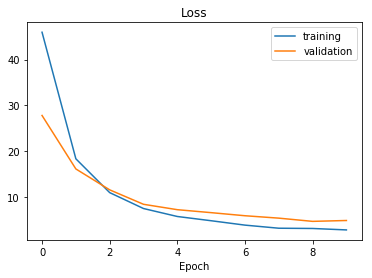

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [31]:
model.save('model.h5')

## Run Test Data

In [32]:
def new_generator(df):
    while True:
        paths_series  =  "driving_dataset/" + df['files']

        imgs = np.asarray(list(map(preprocess_img, paths_series)))

        yield imgs

In [33]:
test_pred = model.predict_generator(new_generator(test_df),1 )

In [34]:
test_pred

array([[-9.527071  ],
       [19.53779   ],
       [ 0.37830758],
       ...,
       [-3.6643147 ],
       [-1.163045  ],
       [ 5.295986  ]], dtype=float32)

In [35]:
mse = mean_squared_error(test_df.angles, test_pred)
r2 = r2_score(test_df.angles, test_pred)
print('Test set mean squared error = ', mse)
print('Test set R2 = ', r2)

Test set mean squared error =  5.243600609401129
Test set R2 =  0.9411402150313458


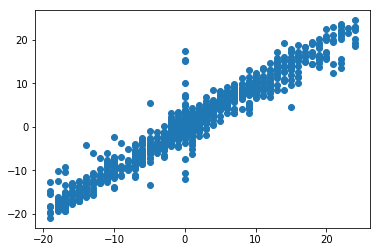

In [36]:
plt.scatter(test_df.angles,test_pred)